In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import src.load as load
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn.utils import weight_norm
import take_two.models as models
from take_two.dataset import Data_Take2
import take_two.training as utils
import take_two.trainingpt2 as utils2
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader



In [3]:
meta, y, schedule, mappings, reverse_mappings = load.load_data('../data/processed/')

train_meta = meta[meta['Year'] != 2024]
test_meta = meta[meta['Year'] == 2024]

train_y = y[y.index.isin(train_meta.index)]
test_y = y[y.index.isin(test_meta.index)]

In [4]:
def make_dataset(meta, y, schedule, mappings):
    features = np.column_stack([
    meta['Ha'].to_numpy(),  # Hectares
    meta['WeekSin'].to_numpy(),  # Week sine
    meta['WeekCos'].to_numpy(),  # Week cosine
    meta['Year'].to_numpy() - 2010,                  # Year
    np.ones(len(meta))                    # Constant feature
])
    mapped_arrays = [meta[column].astype(str).map(mappings[column]).to_numpy() for column in ['ProducerCode','Parcel','Class','Type','Variety']]
    encoded_features = np.column_stack(mapped_arrays)

    climate_data = np.array(meta.ClimateSeries.to_list())
    schedule_data = schedule.values
    kilo_dist = (y.to_numpy() / y.to_numpy().sum(axis=1, keepdims=True)).cumsum(axis=1)
    yield_dist = np.log1p(y.to_numpy() / meta['Ha'].to_numpy()[:, np.newaxis])
    yield_log = np.log1p(y.to_numpy().sum(axis=1) / meta['Ha'].to_numpy())

    train_dataset = Data_Take2(
        features,
        encoded_features,
        climate_data,
        yield_dist,
        kilo_dist,
        yield_log,
        schedule_data
    )
    return train_dataset

In [5]:
train_meta = meta[meta['Year'] != 2024]
test_meta = meta[meta['Year'] == 2024]

train_y = y[y.index.isin(train_meta.index)]
test_y = y[y.index.isin(test_meta.index)]

train_schedule = schedule[schedule.index.isin(train_meta.index)]
test_schedule = schedule[schedule.index.isin(test_meta.index)]

train_dataset = make_dataset(train_meta, train_y, train_schedule, mappings)
test_dataset = make_dataset(test_meta, test_y, test_schedule, mappings)

In [7]:
models=utils2.train_full(train_dataset, test_dataset, 20, 100)

/Users/zakir/anaconda3/envs/cherry/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1, Loss: 87601707.01754385, Val Loss: 152107224.0
Epoch 2, Loss: 87090081.68421052, Val Loss: 151685266.66666666
Epoch 3, Loss: 87268220.91228071, Val Loss: 145062261.33333334
Epoch 4, Loss: 87363183.57894737, Val Loss: 144186960.0
Epoch 5, Loss: 86459470.10526316, Val Loss: 144271218.66666666
Epoch 6, Loss: 84563208.49122807, Val Loss: 109564373.33333333
Epoch 7, Loss: 72104377.43859649, Val Loss: 84581634.66666667
Epoch 8, Loss: 65629580.14035088, Val Loss: 88913690.66666667
Epoch 9, Loss: 63158443.01754386, Val Loss: 99365773.33333333
Epoch 10, Loss: 61122057.298245616, Val Loss: 124640864.0
Epoch 11, Loss: 58635846.350877196, Val Loss: 122256341.33333333
Epoch 12, Loss: 58155781.01754386, Val Loss: 122355562.66666667
Epoch 13, Loss: 57731776.561403506, Val Loss: 133927512.0
Epoch 14, Loss: 58167564.0, Val Loss: 146292058.66666666
Epoch 15, Loss: 57358665.614035085, Val Loss: 140036330.66666666
Epoch 16, Loss: 57057209.05263158, Val Loss: 147004786.66666666
Epoch 17, Loss: 567

In [16]:
base_dir = "models"
os.makedirs(base_dir, exist_ok=True)

In [29]:
for key in models:
    week_dir = os.path.join(base_dir, f"week_{key}")
    os.makedirs(week_dir, exist_ok=True)
    for thingy in models[key]:
        model = models[key][thingy]
        model_path = os.path.join(week_dir, thingy[:-5]+ f"{key}.pt")
        torch.save(model.state_dict(), model_path)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [7]:
criterion = nn.MSELoss()

dist_model = models.DistModel()
dist_optimizer = torch.optim.Adam(dist_model.parameters(), lr=1e-4,weight_decay=1e-4)
dist_scheduler = torch.optim.lr_scheduler.StepLR(dist_optimizer, step_size=20, gamma=0.5)

yield_model = models.YieldModel()
yield_optimizer = torch.optim.Adam(yield_model.parameters(), lr=1e-4,weight_decay=1e-4)
yield_scheduler = torch.optim.lr_scheduler.StepLR(yield_optimizer, step_size=20, gamma=0.5)

sched_model = models.ScheduleModel()
sched_optimizer = torch.optim.Adam(sched_model.parameters(), lr=1e-4,weight_decay=1e-4)
sched_scheduler = torch.optim.lr_scheduler.StepLR(sched_optimizer, step_size=20, gamma=0.5)


/Users/zakir/anaconda3/envs/cherry/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/Users/zakir/anaconda3/envs/cherry/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [34]:
rates = [(1,20),(10,20),(14,10),(20,10),(25,5),(14,10),(10,20)]
for week, epochs in rates:
    utils.train_yield_model(yield_model, yield_optimizer, yield_scheduler, criterion, train_dataloader, test_dataloader, num_weeks=week, num_epochs=epochs)

    

Epoch 1, Loss: 25725396.402654868, Val Loss: 27402413.166666668
Epoch 2, Loss: 19466554.78761062, Val Loss: 36048906.666666664
Epoch 3, Loss: 17379469.24557522, Val Loss: 35227495.333333336
Epoch 4, Loss: 16985796.845132742, Val Loss: 36761059.666666664
Epoch 5, Loss: 16902372.74557522, Val Loss: 37180607.0
Epoch 6, Loss: 16854212.311946902, Val Loss: 36828796.5
Epoch 7, Loss: 16996491.816371683, Val Loss: 40940153.333333336
Epoch 8, Loss: 16819519.792035397, Val Loss: 37504096.333333336
Epoch 9, Loss: 16775377.909292035, Val Loss: 36979588.333333336
Epoch 10, Loss: 16834687.685840707, Val Loss: 35450074.333333336
Epoch 11, Loss: 16871836.805309735, Val Loss: 34469355.166666664
Epoch 12, Loss: 16781874.53318584, Val Loss: 34609447.166666664
Epoch 13, Loss: 16772435.269911505, Val Loss: 34352274.666666664
Epoch 14, Loss: 16687073.670353983, Val Loss: 38652623.5
Epoch 15, Loss: 16722816.384955753, Val Loss: 32957911.666666668
Epoch 16, Loss: 16816621.123893805, Val Loss: 36030578.1666666

In [8]:
rates = [(1,20),(10,20),(14,10),(20,10),(25,5),(14,10),(10,20)]
for week, epochs in rates:
    print(f"Training dist model for {week} weeks for {epochs} epochs")
    utils.train_dist_model(dist_model, dist_optimizer, dist_scheduler, criterion, train_dataloader, test_dataloader, num_weeks=week, num_epochs=epochs)

Training dist model for 1 weeks for 20 epochs
Epoch 1, Loss: 33648845.14159292, Val Loss: 29184596.0
Epoch 2, Loss: 11686162.017699115, Val Loss: 14184207.0
Epoch 3, Loss: 3446790.913716814, Val Loss: 6665281.958333333
Epoch 4, Loss: 1627661.5107853983, Val Loss: 4788961.791666667
Epoch 5, Loss: 1165227.9828539824, Val Loss: 3371275.0416666665
Epoch 6, Loss: 978215.3668418141, Val Loss: 2932433.875
Epoch 7, Loss: 879092.2903761062, Val Loss: 2513432.9583333335
Epoch 8, Loss: 816655.5165929204, Val Loss: 2475068.0833333335
Epoch 9, Loss: 778216.0496404867, Val Loss: 2281509.0
Epoch 10, Loss: 754775.9406803098, Val Loss: 2283073.0208333335
Epoch 11, Loss: 728280.8455475664, Val Loss: 2354472.125
Epoch 12, Loss: 716646.5566924779, Val Loss: 2108589.3020833335
Epoch 13, Loss: 701239.7953539822, Val Loss: 2325607.4583333335
Epoch 14, Loss: 689600.7859513274, Val Loss: 2132738.4895833335
Epoch 15, Loss: 683105.2769634955, Val Loss: 2193139.0833333335
Epoch 16, Loss: 671034.0852461283, Val Lo

In [9]:
rates = [(1,20),(10,20),(14,10),(20,10),(25,5),(14,10),(10,20)]
for week, epochs in rates:
    print(f"Training dist model for {week} weeks for {epochs} epochs")
    utils.train_sched_model(sched_model, sched_optimizer, sched_scheduler, criterion, train_dataloader, test_dataloader, num_weeks=week, num_epochs=epochs)

Training dist model for 1 weeks for 20 epochs
Epoch 1, Loss: 14285499333.097345, Val Loss: 20658916181.333332
Epoch 2, Loss: 11476234560.566372, Val Loss: 12116888405.333334
Epoch 3, Loss: 7397411214.725664, Val Loss: 5593354496.0
Epoch 4, Loss: 4176249248.8495574, Val Loss: 1670754880.0
Epoch 5, Loss: 1998150923.6106195, Val Loss: 1874990656.0
Epoch 6, Loss: 1098756330.2654867, Val Loss: 2380785056.0
Epoch 7, Loss: 785626245.8053098, Val Loss: 2332829290.6666665
Epoch 8, Loss: 614437215.221239, Val Loss: 2152000032.0
Epoch 9, Loss: 501237910.79646015, Val Loss: 1634353002.6666667
Epoch 10, Loss: 421360427.3982301, Val Loss: 1445940906.6666667
Epoch 11, Loss: 369161229.6637168, Val Loss: 1256942810.6666667
Epoch 12, Loss: 335698465.2743363, Val Loss: 998173066.6666666
Epoch 13, Loss: 315214146.05309737, Val Loss: 1078272394.6666667
Epoch 14, Loss: 302490437.38053095, Val Loss: 830723789.3333334
Epoch 15, Loss: 293007518.79646015, Val Loss: 859920000.0
Epoch 16, Loss: 285083435.0442478,

torch.save(dist_model.state_dict(), 'dist_model.pth')
torch.save(sched_model.state_dict(), 'sched_model.pth')
torch.save(yield_model.state_dict(), 'yield_model.pth')


torch.save(test_dataloader, 'test_dataloader.pth')
torch.save(train_dataloader, 'train_dataloader.pth')

In [35]:
num_weeks = 1
yield_results = []
dist_results = []
sched_results = []

yield_model.eval()
dist_model.eval()
sched_model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        features, encoded_features, climate_data, yield_dist, kilo_dist, yield_log, schedule, idx = batch
        kilo_gru_input = kilo_dist[:,:num_weeks,:]
        yield_gru_input = yield_dist[:,:num_weeks,:]
        yield_output = yield_model(features, encoded_features, climate_data, yield_gru_input).squeeze(-1).detach().numpy()
        yield_results.append(yield_output)

        dist_output = dist_model(features, encoded_features, climate_data, kilo_gru_input).squeeze(-1).detach().numpy()
        dist_results.append(dist_output)
        sched_output = sched_model(features, encoded_features, climate_data, kilo_gru_input).squeeze(-1).detach().numpy()
        sched_results.append(sched_output)

print(len(yield_results))
print(len(dist_results))
print(len(sched_results))





6
6
6


In [36]:
yield_results = np.concatenate(yield_results)
dist_results = np.concatenate(dist_results)
sched_results = np.concatenate(sched_results)



In [37]:
hectares = test_dataset.features[:,0].detach().numpy()

In [38]:
pred_yield = np.exp(yield_results)

In [39]:
pred_kilos = pred_yield * hectares

In [40]:
actual_yield = np.exp(test_dataset.Y_yield_log.detach().numpy())

In [41]:
actual_kilos = actual_yield * hectares

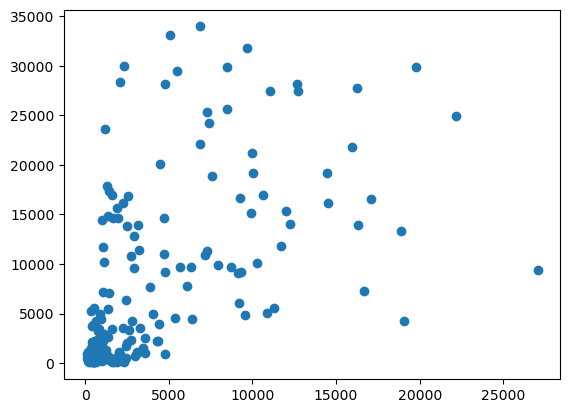

In [42]:
plt.scatter(pred_kilos,actual_kilos)

In [43]:
test_meta['Actual_Kilos'] = actual_kilos

/var/folders/fb/78nymm551yn_7vm06j_3sk9w0000gn/T/ipykernel_81514/2403000849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['Actual_Kilos'] = actual_kilos


In [44]:
test_meta['Predicted_Kilos'] = pred_kilos

/var/folders/fb/78nymm551yn_7vm06j_3sk9w0000gn/T/ipykernel_81514/3021269033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['Predicted_Kilos'] = pred_kilos


In [45]:
grouped = test_meta.groupby('Type').agg({'Ha': 'sum', 'Actual_Kilos': 'sum', 'Predicted_Kilos': 'sum'})

In [46]:
grouped

,Ha,Actual_Kilos,Predicted_Kilos
Type,,,
Cherry Naranja,1.0469,9923.046875,12324.154297
Cherry Rojo,19.9773,515681.968750,230324.859375
Cherry Rosa,4.2565,60967.250000,60739.855469
Pera Amarilla,1.6648,10835.664062,16381.186523
Pera Roja,1.3811,6139.380859,13365.826172
Uva Amarilla,3.6850,38801.683594,37071.941406
Uva Roja,29.7352,777137.250000,377923.031250
